In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anirudhcv/labeled-optical-coherence-tomography-oct")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/labeled-optical-coherence-tomography-oct


In [8]:
import os
import kagglehub

# Download latest version
downloaded_path = kagglehub.dataset_download("anirudhcv/labeled-optical-coherence-tomography-oct")

print("Path to downloaded dataset files:", downloaded_path)

# Veri seti yolu: kagglehub tarafından indirilen path'i kullan
# İndirilen path'in içindeki 'Dataset - train+val+test' klasörüne işaret etmesi gerekiyor.
dataset_path = os.path.join(downloaded_path, "Dataset - train+val+test")

# Sınıf sayımlarını hesaplayan fonksiyon
def count_images_in_folder(folder_path):
    """Verilen klasördeki sınıfların görsel sayılarını hesaplar."""
    class_counts = {}
    # Check if the folder_path exists before listing
    if not os.path.exists(folder_path):
        print(f"Hata: Klasör bulunamadı: {folder_path}")
        return class_counts # Return empty if folder doesn't exist

    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            num_images = len([name for name in os.listdir(class_folder) if os.path.isfile(os.path.join(class_folder, name))])
            class_counts[class_name] = num_images
    return class_counts

# Klasörleri tara ve sınıf sayılarını yazdır
for folder in ['train', 'val', 'test']:
    folder_path = os.path.join(dataset_path, folder)
    print(f"\n'{folder}' klasöründeki içerikler:")

    class_counts = count_images_in_folder(folder_path)
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} görsel")

Path to downloaded dataset files: /kaggle/input/labeled-optical-coherence-tomography-oct

'train' klasöründeki içerikler:
  DRUSEN: 6206 görsel
  CNV: 26218 görsel
  NORMAL: 35973 görsel
  DME: 8118 görsel

'val' klasöründeki içerikler:
  DRUSEN: 1773 görsel
  CNV: 7491 görsel
  NORMAL: 10278 görsel
  DME: 2319 görsel

'test' klasöründeki içerikler:
  DRUSEN: 887 görsel
  CNV: 3746 görsel
  NORMAL: 5139 görsel
  DME: 1161 görsel


In [10]:
# === Veri yolu ===
# dataset_path = "/kaggle/input/labeled-optical-coherence-tomography-oct/Dataset - train+val+test" # Remove this hardcoded path

# Use the path obtained from kagglehub.dataset_download
# downloaded_path is defined in the previous cell
dataset_path = os.path.join(downloaded_path, "Dataset - train+val+test")

# Import tensorflow
import tensorflow as tf

# === Dataset yükle ===
def load_datasets():
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(dataset_path, "train"),
        image_size=(224, 224),
        label_mode="categorical",
        batch_size=64,
        shuffle=True,
        seed=123
    )
    val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(dataset_path, "val"),
        image_size=(224, 224),
        label_mode="categorical",
        batch_size=64,
        shuffle=True,
        seed=123
    )
    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(dataset_path, "test"),
        image_size=(224, 224),
        label_mode="categorical",
        batch_size=64,
        shuffle=False
    )

    return train_dataset.cache().prefetch(tf.data.AUTOTUNE), \
           val_dataset.cache().prefetch(tf.data.AUTOTUNE), \
           test_dataset.cache().prefetch(tf.data.AUTOTUNE)

# Call the load_datasets function and assign the returned values
train_dataset, val_dataset, test_dataset = load_datasets()

Found 76515 files belonging to 4 classes.
Found 21861 files belonging to 4 classes.
Found 10933 files belonging to 4 classes.


In [17]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
# ImageDataGenerator artık bu yaklaşım için kullanılmadığı için import kaldırıldı
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parametreler
img_height, img_width = 224, 224
# batch_size = 32 # Batch size veri setlerini oluştururken zaten tanımlandı
num_classes = 4  # Sınıf sayısını güncelle (Normal, CNV, DME, DRUSEN olmak üzere 4 sınıf var)

# Modeli oluştur
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Katmanları dondur
base_model.trainable = False

# Üst katmanları ekle
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Derleme
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Eğitme
# image_dataset_from_directory ile oluşturulan veri setlerini doğrudan kullanın
history = model.fit(
    train_dataset,     # train_dataset'i kullanın
    validation_data=val_dataset, # val_dataset'i kullanın
    epochs=10
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 151s 100ms/step - accuracy: 0.8092 - loss: 0.5474 - val_accuracy: 0.8956 - val_loss: 0.3056
Epoch 2/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.8847 - loss: 0.3332 - val_accuracy: 0.9087 - val_loss: 0.2709
Epoch 3/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.8927 - loss: 0.3111 - val_accuracy: 0.9113 - val_loss: 0.2595
Epoch 4/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.8946 - loss: 0.3012 - val_accuracy: 0.9138 - val_loss: 0.2506
Epoch 5/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.8975 - loss: 0.2956 - val_accuracy: 0.9147 - val_loss: 0.2474
Epoch 6/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.8982 - loss: 0.2941 - val_accuracy: 0.9172 - val_loss: 0.2424
Epoch 7/10
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.8972 - loss: 0.2961 - val_accuracy: 0.9180 - val_loss: 0.2395
Epoch 8/10
1196/1196 ━━

Found 76515 files belonging to 4 classes.
Found 21861 files belonging to 4 classes.
Found 10933 files belonging to 4 classes.


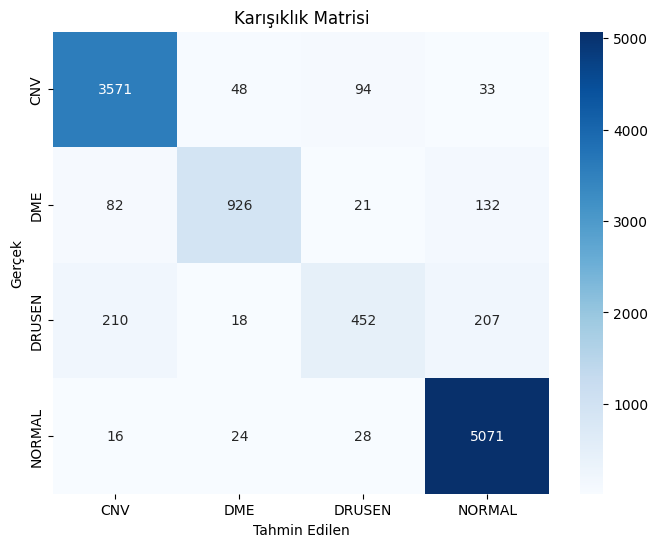

              precision    recall  f1-score       support
CNV            0.920598  0.953284  0.936656   3746.000000
DME            0.911417  0.797588  0.850712   1161.000000
DRUSEN         0.759664  0.509583  0.609987    887.000000
NORMAL         0.931655  0.986768  0.958420   5139.000000
accuracy       0.916491  0.916491  0.916491      0.916491
macro avg      0.880834  0.811806  0.838944  10933.000000
weighted avg   0.911764  0.916491  0.911256  10933.000000
F1 Score (macro): 0.8389
Precision (macro): 0.8808
Recall (macro): 0.8118

F1 Score (weighted): 0.9113
Precision (weighted): 0.9118
Recall (weighted): 0.9165


In [25]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf # Import tensorflow to access test_dataset
import os # Import os for path joining

# Make sure dataset_path is accessible (it should be from the previous cells)
# If not, uncomment and define it based on your downloaded data path
# downloaded_path = kagglehub.dataset_download("anirudhcv/labeled-optical-coherence-tomography-oct")
# dataset_path = os.path.join(downloaded_path, "Dataset - train+val+test")

# === Dataset yükle ===
def load_datasets():
    # Create datasets using image_dataset_from_directory
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(dataset_path, "train"),
        image_size=(224, 224),
        label_mode="categorical",
        batch_size=64,
        shuffle=True,
        seed=123
    )
    val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(dataset_path, "val"),
        image_size=(224, 224),
        label_mode="categorical",
        batch_size=64,
        shuffle=True,
        seed=123
    )
    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(dataset_path, "test"),
        image_size=(224, 224),
        label_mode="categorical",
        batch_size=64,
        shuffle=False
    )

    # Store class_names before applying cache() and prefetch()
    class_names = train_dataset.class_names # Class names should be the same for all splits

    # Apply cache() and prefetch() and return the processed datasets along with class names
    return train_dataset.cache().prefetch(tf.data.AUTOTUNE), \
           val_dataset.cache().prefetch(tf.data.AUTOTUNE), \
           test_dataset.cache().prefetch(tf.data.AUTOTUNE), \
           class_names

# Call the load_datasets function and assign the returned values
# Also assign the class_names returned by the function
train_dataset, val_dataset, test_dataset, class_names = load_datasets()


# Test verisi için ImageDataGenerator kullanmak yerine
# Daha önce tf.keras.preprocessing.image_dataset_from_directory ile oluşturulmuş
# test_dataset'i kullanın.

# Tahminleri yap
# model.predict artık test_generator yerine test_dataset'i kabul ediyor.
# verbose=0 ekleyerek prediction ilerlemesini göstermeyebilirsiniz.
predictions = model.predict(test_dataset, verbose=0)

# Gerçek etiketleri test_dataset'ten alın
# image_dataset_from_directory'den gelen veri setleri (görseller, etiketler) tuple'ları içerir.
# Etiketler genellikle tuple'ın ikinci öğesidir.
# tf.concat kullanarak tüm batchlerdeki etiketleri birleştiriyoruz.
y_true = tf.concat([y for x, y in test_dataset], axis=0)
# Etiketler one-hot encoding formatında olduğu için en yüksek değere sahip indeksi alıyoruz.
y_true = np.argmax(y_true, axis=1)

y_pred = np.argmax(predictions, axis=1)

# Sınıf etiketlerini daha önce load_datasets fonksiyonundan aldığımız class_names listesinden alın
# class_labels = test_dataset.class_names # This line caused the error
class_labels = class_names # Use the stored class_names

# Karışıklık Matrisi
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Karışıklık Matrisi')
plt.show()

# Sınıflandırma Raporu
report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

# F1, Precision, Recall (Makro ve Ağırlıklı)
f1_macro = f1_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')

f1_weighted = f1_score(y_true, y_pred, average='weighted')
precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')

print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro): {recall_macro:.4f}\n")

print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"Precision (weighted): {precision_weighted:.4f}")
print(f"Recall (weighted): {recall_weighted:.4f}")

# Excel'e kaydet
report_df.to_excel("efficientnetb0_sonuclar.xlsx", index=True)

In [29]:
model.save("efficientnetb0_model.keras")
